In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.stats.qmc

<IPython.core.display.Javascript object>


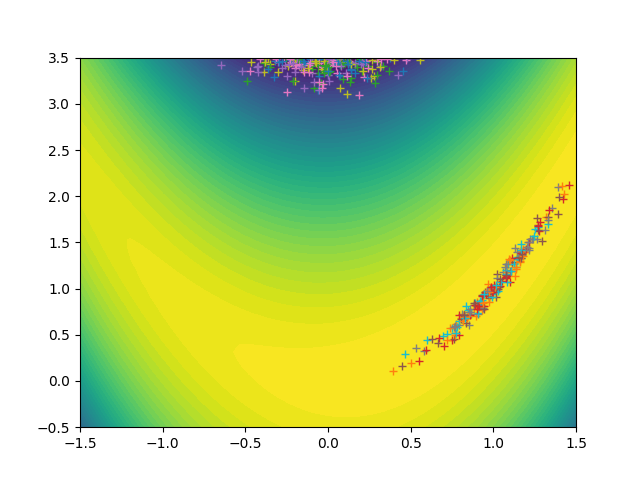

In [2]:
def himmelblau(x,y,):
    return (((x**2+y-11)**2) + (((x+y**2-7)**2)))
def rosenbrock(x,y, b=10):
    return (x-1)**2 + b*(y-x**2)**2
#x=np.linspace(-2,3.5)
#X,Y= np.meshgrid(x,x)
#Z = himmelblau(X,Y)
x=np.linspace(-1.5,1.5)
y=np.linspace(-0.5,3.5)
X,Y= np.meshgrid(x,y)
Z = rosenbrock(X,Y)
fig = plt.figure()
#ax = fig.gca(projection='3d')
# ax.plot_surface(X,Y,Z,cmap='gist_heat_r')
ax = fig.gca()
ax.contourf(X,Y,Z,levels=50, cmap='viridis_r')
ax.plot(1,1,ls='none',marker='o')
ax.plot(0,3.5,ls='none',marker='o')

<IPython.core.display.Javascript object>


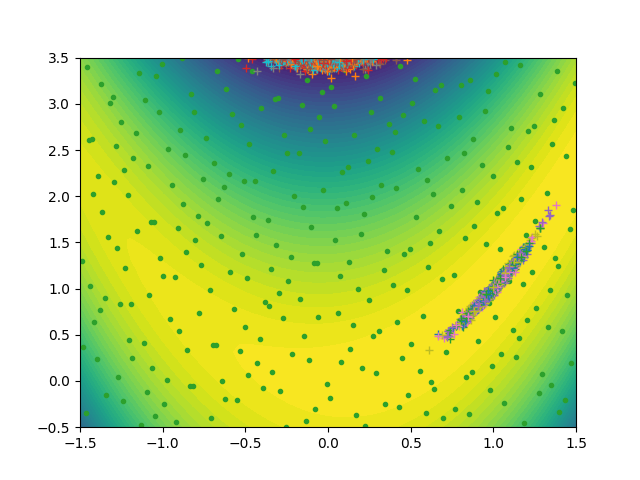

<IPython.core.display.Javascript object>


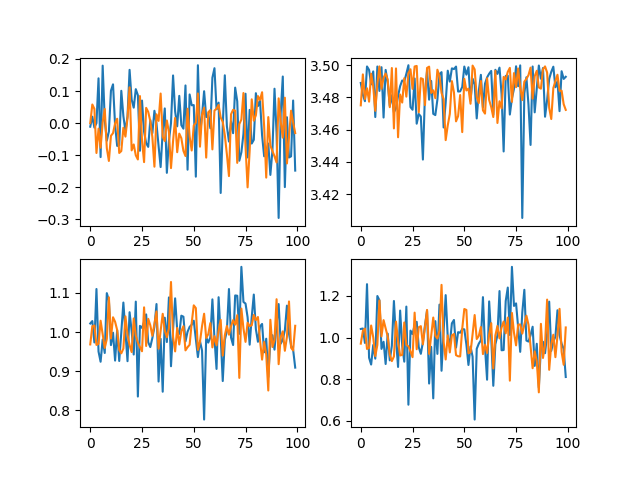

In [3]:

confidence = np.empty((8,20,2)) #2 each of: maxmc, maxqmc, minmc, minqmc
for k in range(confidence.shape[1]):
    N_mcs=k+1
    N_mcs*=100
    
    if k ==2:
        fig = plt.figure()
        #ax = fig.gca(projection='3d')
        # ax.plot_surface(X,Y,Z,cmap='gist_heat_r')
        ax = fig.gca()
        ax.contourf(X,Y,Z,levels=50, cmap='viridis_r')
        ax.plot(1,1,ls='none',marker='o')
        ax.plot(0,3.5,ls='none',marker='o')
        
    maxmc = np.empty((2,100)) # 100 random trials of approximate interval optimization
    minmc, maxqmc, minqmc = np.empty_like(maxmc), np.empty_like(maxmc), np.empty_like(maxmc)

    for i in range(maxmc.shape[1]):
        engine = scipy.stats.qmc.Halton(2)
        xy = engine.random(N_mcs).T

        xy[0,:] = scipy.stats.uniform(-1.5,3).ppf(xy[0,:])
        xy[1,:] = scipy.stats.uniform(-.5,4).ppf(xy[1,:])

        z = rosenbrock(xy[0,:],xy[1,:])
        maxxy = xy[:,np.argmax(z)]
        maxz = np.max(z)
        minxy = xy[:,np.argmin(z)]
        minz = np.min(z)
        maxqmc[:,i]=maxxy
        minqmc[:,i]=minxy
        if k == 2 and i ==0:
            # ax.plot(*xy,z, ls='none', marker=',')
            # ax.plot(*maxxy,maxz, ls='none', marker='x')
            # ax.plot(*minxy,minz, ls='none', marker='x')

            ax.plot(*xy, ls='none', marker='.')
            ax.plot(*maxxy, ls='none', marker='x')
            ax.plot(*minxy, ls='none', marker='x')

        xy = np.random.random((N_mcs,2)).T

        xy[0,:] = scipy.stats.uniform(-1.5,3).ppf(xy[0,:])
        xy[1,:] = scipy.stats.uniform(-.5,4).ppf(xy[1,:])

        z = rosenbrock(xy[0,:],xy[1,:])
        maxxy = xy[:,np.argmax(z)]
        maxz = np.max(z)
        minxy = xy[:,np.argmin(z)]
        minz = np.min(z)

        maxmc[:,i]=maxxy
        minmc[:,i]=minxy
        
#         if i ==0:
            # ax.plot(*xy,z, ls='none', marker=',')
            # ax.plot(*maxxy,maxz, ls='none', marker='x')
            # ax.plot(*minxy,minz, ls='none', marker='x')

#         ax.plot(*xy, ls='none', marker=',')
        ax.plot(*maxxy, ls='none', marker='+')
        ax.plot(*minxy, ls='none', marker='+')


    
    (maxmc[0,:],maxmc[1,:],minmc[0,:],minmc[1,:],maxqmc[0,:],maxqmc[1,:],minqmc[0,:],minqmc[1,:])
    for j, a in enumerate((maxmc[0,:],maxmc[1,:],minmc[0,:],minmc[1,:],maxqmc[0,:],maxqmc[1,:],minqmc[0,:],minqmc[1,:])):
        confidence[j,k,:] = scipy.stats.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=scipy.stats.sem(a))
fig, axes = plt.subplots(2,2)
ax1,ax2,ax3,ax4 = axes.flat
ax1.plot(maxmc[0,:])
ax2.plot(maxmc[1,:])
ax3.plot(minmc[0,:])
ax4.plot(minmc[1,:])
ax1.plot(maxqmc[0,:])
ax2.plot(maxqmc[1,:])
ax3.plot(minqmc[0,:])
ax4.plot(minqmc[1,:])

<IPython.core.display.Javascript object>


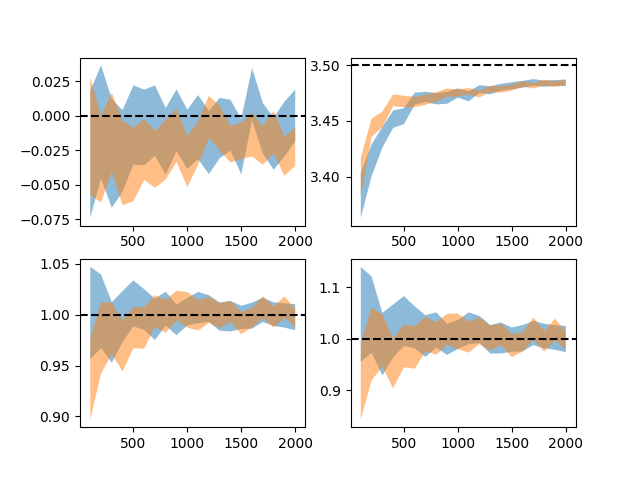

In [4]:
fig, axes = plt.subplots(2,2)
ax1,ax2,ax3,ax4 = axes.flat
x = np.arange(1,confidence.shape[1]+1)*100
ax1.axhline(0, c='k',ls='--')
ax2.axhline(3.5, c='k',ls='--')
ax3.axhline(1, c='k',ls='--')
ax4.axhline(1, c='k',ls='--')

ax1.fill_between(x,confidence[0,:,0],confidence[0,:,1],alpha=.5)
ax2.fill_between(x,confidence[1,:,0],confidence[1,:,1],alpha=.5)
ax3.fill_between(x,confidence[2,:,0],confidence[2,:,1],alpha=.5)
ax4.fill_between(x,confidence[3,:,0],confidence[3,:,1],alpha=.5)
ax1.fill_between(x,confidence[4,:,0],confidence[4,:,1],alpha=.5)
ax2.fill_between(x,confidence[5,:,0],confidence[5,:,1],alpha=.5)
ax3.fill_between(x,confidence[6,:,0],confidence[6,:,1],alpha=.5)
ax4.fill_between(x,confidence[7,:,0],confidence[7,:,1],alpha=.5)

<IPython.core.display.Javascript object>


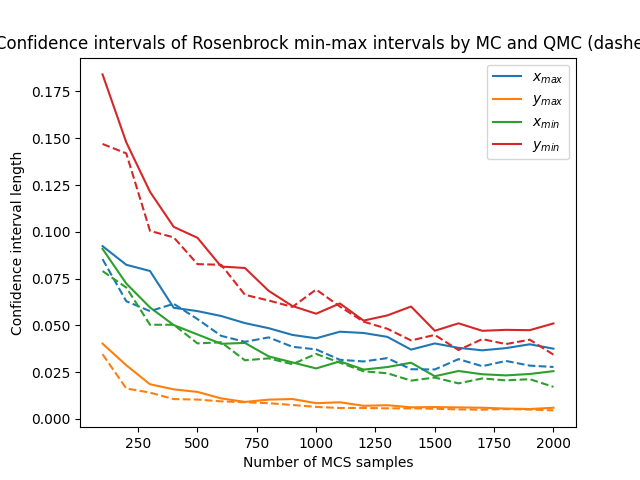

In [18]:
plt.figure()
dc = np.diff(confidence, axis=2).squeeze()

line_objs = plt.plot(x,dc[:4,:].T, )
plt.gca().set_prop_cycle(None)
plt.plot(x,dc[4:,:].T, ls='--')
plt.gca().legend(line_objs,['$x_{max}$','$y_{max}$','$x_{min}$','$y_{min}$'])
plt.ylabel("Confidence interval length")
plt.xlabel("Number of MCS samples")
plt.title("Confidence intervals of Rosenbrock min-max intervals by MC and QMC (dashed)")
plt.show()

#### approximation of CDFs by intervals and uniform sampling ####

<IPython.core.display.Javascript object>


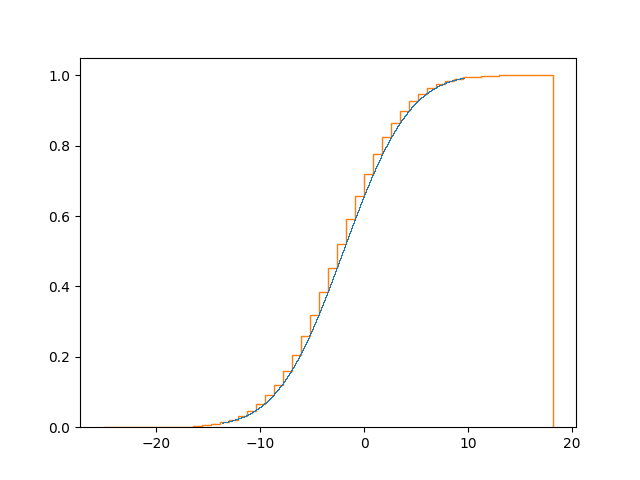

-1.9882186117506524 5.085602733629414


In [239]:
N_mcs = 100000
# normal RV with mu = -2, sigma = 5
rv = scipy.stats.norm(-2, 5)
# get support (define upper and lower bounds, e.g. 99 % quantiles, 1% quantiles)
support = rv.ppf([0.01,0.99])
# sample uniform values in support interval
rvu = scipy.stats.uniform(support[0], support[1]-support[0])
rvs = rvu.ppf(np.random.random(N_mcs))
# plot sampled values vs. their CDF
cdf = rv.cdf(rvs)
pdf = rv.pdf(rvs)
plt.figure()
plt.plot(rvs, cdf, ls='none', marker=',')
plt.hist(rv.rvs(N_mcs), bins=50, histtype='step', density=True, cumulative=True)
print(np.average(rvs, weights=pdf), np.sqrt(np.average(rvs**2, weights=pdf)))

#### comparison of standard MCS vs. QMC (uniform) sampling and product probabilities ####

In [589]:
# natural frequency of a SDOF system f = sqrt(k / m)
freq = lambda k,m: np.sqrt(k/m)
damp = lambda k,m,c: c/2/np.sqrt(m*k)
# define log normal RV k: E = 5, Var = 2 
E, Var = 5, 2
mu = np.log(E**2 / np.sqrt(Var + E**2))
s2 = np.log(Var / E**2 + 1)
rvk = scipy.stats.lognorm(np.sqrt(s2),scale = np.exp(mu))
# define /log normal RV m: E = 2, Var = 1
E, Var = 2, 1
mu = np.log(E**2 / np.sqrt(Var + E**2))
s2 = np.log(Var / E**2 + 1)
rvm = scipy.stats.lognorm(np.sqrt(s2),scale = np.exp(mu))
# define interval Variable c:  (zeta=0.001, 0.1)
ivc = [5e-1 , 1.9]
rvc = scipy.stats.uniform(ivc[0], ivc[1]-ivc[0]) # for pure aleatory Monte Carlo treat as uniform random variable

/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


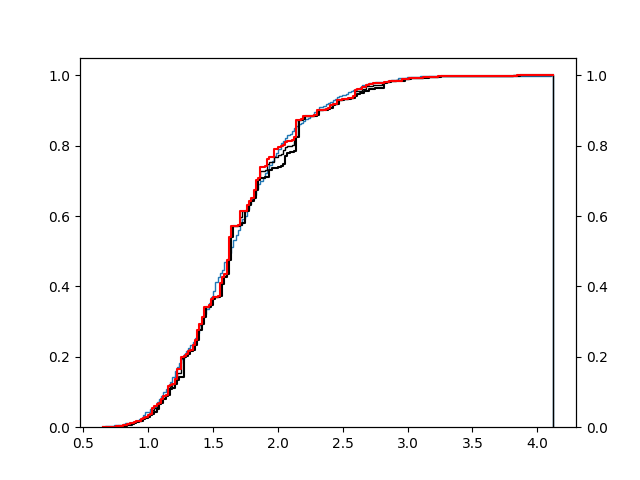

1.686737421965589 0.45958659067333896


In [487]:
N_mcs=1000
# sample N_mcs samples from both
rvks=rvk.rvs(N_mcs)
rvms=rvm.rvs(N_mcs)
# propagate through mapping function
fs = freq(rvks,rvms)
# draw histogram
plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
_,binsf,_ = ax.hist(fs, bins=200, histtype='step', density=True, cumulative=True)
# compute statistical moments
print(np.mean(fs), np.std(fs))

/vegas/apps/compiler/intel/intelpython3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


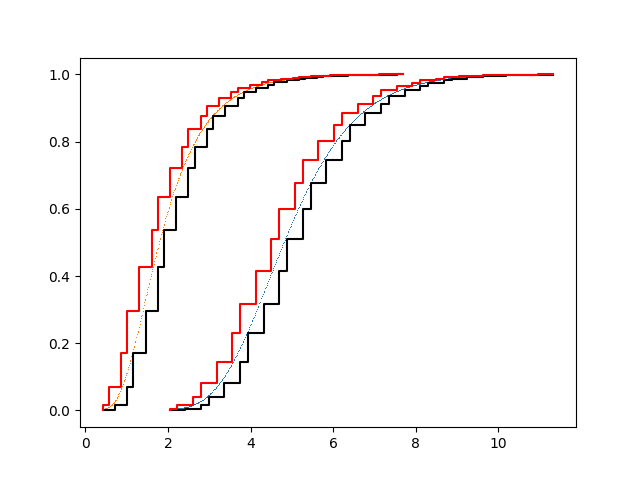

We have an average number of 0.5202913631633714 samples per bin (min: 0.0, max: 2.0, expected: 0.5202913631633714)
1.6995090753297248 0.4692716548297536


In [506]:
ax2.clear()
N_mcs = 500
# get support (define upper and lower bounds, e.g. 99 % quantiles, 1% quantiles) (truncated)
suppk = rvk.ppf([0.001,0.999])
suppm = rvm.ppf([0.001,0.999])

# sample N_mcs samples from a Halton Sequence and transform to uniform bounds
engine = scipy.stats.qmc.Halton(2)
xy = engine.random(N_mcs).T
rvuk = scipy.stats.uniform(suppk[0], suppk[1]-suppk[0])
rvum = scipy.stats.uniform(suppm[0], suppm[1]-suppm[0])
rvsk = rvuk.ppf(xy[0,:])
rvsm = rvum.ppf(xy[1,:])

# compute cdf and pdf value for each input sample
cdfk = rvk.cdf(rvsk)
pdfk = rvk.pdf(rvsk)
pdfk /= pdfk.sum()
cdfm = rvm.cdf(rvsm)
pdfm = rvm.pdf(rvsm)
pdfm /= pdfm.sum()

# compute joint pdf of each sample
pdfkm = pdfk * pdfm
pdfkm /= pdfkm.sum()

# plot input cdfs (weighted histograms)
plt.figure()
plt.plot(rvsk, cdfk, ls='none', marker=',')
# plt.hist(rvks, bins=50, histtype='step', density=True, cumulative=True
plt.plot(rvsm, cdfm, ls='none', marker=',')
# plt.hist(rvms, bins=50, histtype='step', density=True, cumulative=True)

# propagate through mapping function
fs = freq(rvsk,rvsm)

# compute and plot weighted histogram
ax2.hist(fs, bins=binsf, histtype='step', color='black', density=True, cumulative=True, weights=pdfkm)

# build hypercubes
# compute mass function of output on all input hypercubes
# larger bins artificially increase bel-pl intervals around the true cdf
# smaller bins finally reduce to singletons, converging asymptotically to the true cdf
# however break approximations of interval optimization  (no intervals exist on singletons)
binsk = np.linspace(*suppk, 31)
focalsk = np.empty((binsk.size,2))
focalsk[:,1]=binsk
focalsk[1:,0] = binsk[:-1]
focalsk[0,0] = -np.infty
massk = np.zeros(binsk.size)

binsm = np.linspace(*suppm, 31)
focalsm = np.empty((binsm.size,2))
focalsm[:,1]=binsm
focalsm[1:,0] = binsm[:-1]
focalsm[0,0] = -np.infty
massm = np.zeros(binsm.size)

nbins = binsk.size * binsm.size
focalsf = np.zeros((nbins, 2))
massf = np.zeros(nbins)
samplesperbin = np.zeros(nbins)

for i in range(binsk.size):
    lbink,ubink = focalsk[i,:] 
        
    indk = np.logical_and(rvsk>lbink, rvsk<=ubink)
    if not indk.any(): continue
        
    massk[i] = np.sum(pdfk[indk])
    
    for j in range(binsm.size):
        lbinm, ubinm = focalsm[j,:]
        indm = np.logical_and(rvsm>lbinm, rvsm<=ubinm)
        if not indm.any(): continue

        massm[j] = np.sum(pdfm[indm])
        
        indkm = np.logical_and(indk, indm)
        if not indkm.any(): continue
            
        samplesperbin[i*binsm.size+j] = np.sum(indkm)
        focalsf[i*binsm.size+j,:] = (fs[indkm].min(), fs[indkm].max())
        massf[i*binsm.size+j] = np.sum(pdfkm[indkm]) 
print(f'We have an average number of {np.mean(samplesperbin)} samples per bin (min: {np.min(samplesperbin)}, max: {np.max(samplesperbin)}, expected: {N_mcs/nbins})')

# generate finer bins and compute and pl
for supp,focals,mass in zip([suppk,suppm],
                            [focalsk,focalsm],
                            [massk,massm]):
    bins = np.linspace(*supp,)
    bel = np.zeros(bins.size)
    pl = np.zeros(bins.size)
    ubin = -np.infty
    for i in range(bins.size):
        lbin = ubin
        ubin = bins[i]

        # get all sets B that are a subset of A
        # that means the lower boundary of B must be greater or equal to the lower boundary of A and similarly for the upper boundary
        belinds = np.logical_and(focals[:,0] >=-np.infty,
                                 focals[:,1] <= ubin)
        bel[i] = np.sum(mass[belinds])
        # get all sets B that intersect with A
        # that means the lower boundary of B must not be higher (= must be strictly lower) than the upper boundary of A (B entirely outside of A to the right)
        # and the upper boundary of B must not be lower (= must be strictly higher) than the lower boundary of A (B  entirely outside of A to the left)
        plinds = np.logical_and(focals[:,0]<ubin, 
                                focals[:,1]>-np.infty, )
        pl[i] = np.sum(mass[plinds])

    bel[-1]=bel[-2]
    pl[-1]=pl[-2]
    plt.step(bins, bel, c='k', where='post')
    plt.step(bins, pl, c='r', where='pre')
    
#     plt.plot(bins, bel, c='k', ls='none', marker='x')
#     plt.plot(bins, pl, c='r', ls='none', marker='x')

# generate evenly distributed bins for fs
# binsf = np.linspace(fs.min(),fs.max(), 201)
# using the same bins as the histogram in the above cell
bel = np.zeros(binsf.size)
pl = np.zeros(binsf.size)
# compute belief and plausibility for each bin

ubinf = -np.infty
for i in range(binsf.size):
    # that is set A
    lbinf = ubinf
    ubinf = binsf[i]
    # get all sets B that are a subset of A
    # that means the lower boundary of B must be greater or equal to the lower boundary of A and similarly for the upper boundary
    belinds = np.logical_and(focalsf[:,0] >=-np.infty,
                             focalsf[:,1] <= ubinf)
    bel[i] = np.sum(massf[belinds])
    # get all sets B that intersect with A
    # that means the lower boundary of B must not be higher (= must be strictly lower) than the upper boundary of A (B entirely outside of A to the right)
    # and the upper boundary of B must not be lower (= must be strictly higher) than the lower boundary of A (B  entirely outside of A to the left)
    plinds = np.logical_and(focalsf[:,0]<ubinf, 
                            focalsf[:,1]>-np.infty, )
#     print(lbinf,ubinf,belinds,plinds)
    pl[i] = np.sum(massf[plinds])
    
#     bel[i] = np.sum(pdfkm[fs<=binsf[i]])
#     pl[i] = np.sum(pdfkm[fs<=binsf[i]])
#     ax2.plot([lbinf, ubinf],[bel[i],bel[i]], c='k')
#     ax2.plot([lbinf, ubinf],[pl[i],pl[i]], c='r')



"""
Asymptotically for decreasing bin size
focal sets become singletons with mass = pdfkm
bel consists of singletons ind = [fs<=ubinf] and bel = sum(pdfkm[ind])
pl consists of singletons ind = [fs<=ubinf] and pl = sum(pdfkm[ind])
"""
bel[-1]=bel[-2]
pl[-1]=pl[-2]
ax2.step(binsf, bel, c='k', where='post')
ax2.step(binsf, pl, c='r', where='pre')
ax2.set_ylim(*ax.get_ylim())
mean=np.average(fs, weights=pdfkm)
std = np.sqrt(np.average((fs - mean)**2, weights=pdfkm))
print(mean, std)

<IPython.core.display.Javascript object>


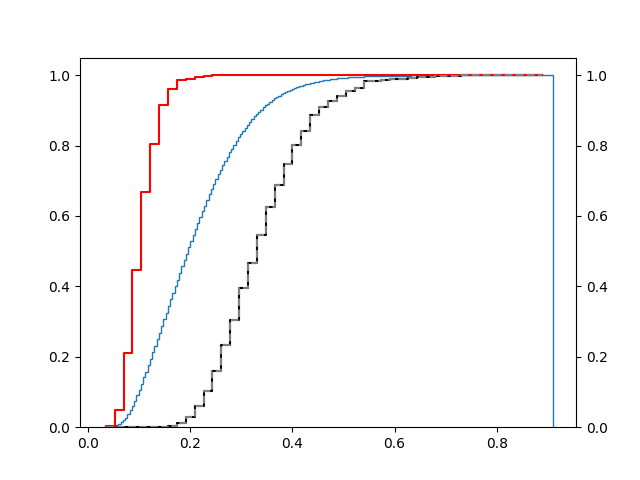

0.21208003960633345 0.09481844495489077


In [599]:
N_mcs=100000
# sample N_mcs samples from both
rvks=rvk.rvs(N_mcs)
rvms=rvm.rvs(N_mcs)
rvcs=rvc.rvs(N_mcs)
# propagate through mapping function
zetas = damp(rvks,rvms, rvcs)
# draw histogram
plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
_,binszeta,_ = ax.hist(zetas, bins=200, histtype='step', density=True, cumulative=True)
# compute statistical moments
print(np.mean(zetas), np.std(zetas))

<IPython.core.display.Javascript object>


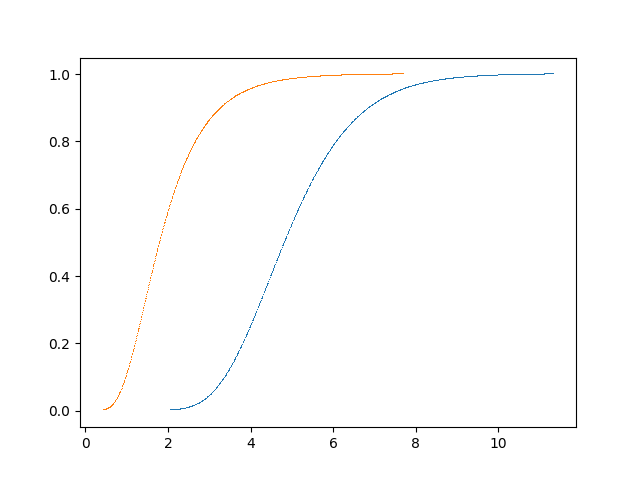

50 50 50
50 50 50


In [612]:
ax2.clear()
N_mcs_ale = 1000
N_mcs_epi = 10
N_mcs = max(N_mcs_ale,N_mcs_epi)
# get support (define upper and lower bounds, e.g. 99 % quantiles, 1% quantiles) (truncated)
suppk = rvk.ppf([0.001,0.999])
suppm = rvm.ppf([0.001,0.999])
suppc = ivc
# define equivalent uniform distributions
rvuk = scipy.stats.uniform(suppk[0], suppk[1]-suppk[0])
rvum = scipy.stats.uniform(suppm[0], suppm[1]-suppm[0])
rvuc = scipy.stats.uniform(suppc[0], suppc[1]-suppc[0])

# sample N_mcs samples from a Halton Sequence and transform to uniform bounds
engine = scipy.stats.qmc.Halton(3)
samples = engine.random(N_mcs)
samples_ale = samples[:N_mcs_ale, 0:2]
for i, rvu in enumerate([rvuk, rvum]):
    samples_ale[:, i] = rvu.ppf(samples_ale[:, i])
samples_epi = samples[:N_mcs_epi, 2:3]
for i, rvu in enumerate([rvuc]):
    samples_epi[:, i] = rvu.ppf(samples_epi[:, i])

# generate grid indices
ind_ale, ind_epi = np.mgrid[0:N_mcs_ale:1, 0:N_mcs_epi:1]
ind_alef = ind_ale.flatten()
ind_epif = ind_epi.flatten()

# compute cdf and pdf value for each input sample
cdfk = rvk.cdf(samples_ale[:, 0])
pdfk = rvk.pdf(samples_ale[:, 0])
pdfk /= pdfk.sum()
cdfm = rvm.cdf(samples_ale[:, 1])
pdfm = rvm.pdf(samples_ale[:, 1])
pdfm /= pdfm.sum()

# compute joint pdf of each sample
pdfkm = pdfk * pdfm
pdfkm /= pdfkm.sum()

# plot input cdfs (weighted histograms)
plt.figure()
plt.plot(samples_ale[:, 0], cdfk, ls='none', marker=',')
# plt.hist(rvks, bins=50, histtype='step', density=True, cumulative=True
plt.plot(samples_ale[:, 1], cdfm, ls='none', marker=',')
# plt.hist(rvms, bins=50, histtype='step', density=True, cumulative=True)

# propagate through mapping function
zetas = damp(samples_ale[ind_alef, 0],samples_ale[ind_alef, 1], samples_epi[ind_epif, 0])

'''
for each epistemic sample: draw histograms -> find min max
for each aleatory sample: draw intervals -> find distribution
'''
binszetas = np.linspace(zetas.min(), zetas.max(), N_mcs_ale//20) # on average 20 aleatory samples per bin

if True:
    focalszeta = np.zeros((N_mcs_ale,3)) #min, max, mass
    for j in range(N_mcs_ale):
        ind = ind_alef==j
        if not ind.any(): continue

        this_zetas = zetas[ind]
        mass = np.sum(pdfkm[j])
        focalszeta[j] = [np.min(this_zetas),np.max(this_zetas),mass]

    bel = np.zeros(binszetas.size)
    pl = np.zeros(binszetas.size)
    ubinzeta = -np.infty
    for i,binzeta in enumerate(binszetas):
        lbinzeta = ubinzeta
        ubinzeta = binzeta
        # get all sets B that are a subset of A
        # that means the lower boundary of B must be greater or equal to the lower boundary of A and similarly for the upper boundary
        belinds = np.logical_and(focalszeta[:,0] >=-np.infty,
                                 focalszeta[:,1] <= ubinzeta)
        bel[i] = np.sum(focalszeta[belinds,2])
        # get all sets B that intersect with A
        # that means the lower boundary of B must not be higher (= must be strictly lower) than the upper boundary of A (B entirely outside of A to the right)
        # and the upper boundary of B must not be lower (= must be strictly higher) than the lower boundary of A (B  entirely outside of A to the left)
        plinds = np.logical_and(focalszeta[:,0]<ubinzeta, 
                                focalszeta[:,1]>-np.infty, )
    #     print(lbinf,ubinf,belinds,plinds)
        pl[i] = np.sum(focalszeta[plinds,2])
    bel[-1]=bel[-2]
    pl[-1]=pl[-2]
    
    print(binszetas.size, bel.size, pl.size)
    ax2.step(binszetas, bel, c='k', where='post')
    ax2.step(binszetas, pl, c='r', where='pre')
    ax2.set_ylim(*ax.get_ylim())    

if True:
    bel = np.ones_like(binszetas)
    pl = np.zeros_like(binszetas)
    for i in range(N_mcs_epi):
        this_zetas = zetas[ind_epif==i]
        hist,_ = np.histogram(this_zetas, bins=np.hstack([np.array([-np.infty]),binszetas]), weights=pdfkm, density=True)
        hist = np.cumsum(hist)
        hist /=hist.max()
        plinds = pl<hist
        pl[plinds] = hist[plinds]
        belinds = bel>hist
        bel[belinds] = hist[belinds]
    print(binszetas.size, bel.size, pl.size)
    ax2.step(binszetas, bel, c='grey', ls='dashed', where='post')
    ax2.step(binszetas, pl, c='lightred', ls='dashed',  where='pre')
    ax2.set_ylim(*ax.get_ylim())   
        

In [529]:
Nsamples=10000
Nperhypercube=11
for Nvariables in range(1,20):
    Nbins = (Nsamples/Nperhypercube)**(1/Nvariables)
    print(Nvariables, Nbins)
    
Nbins=10
for Nvariables in range(1,20):
    Nperhypercube = Nsamples/(Nbins**Nvariables)
    print(Nvariables, Nperhypercube)

Nperhypercube = 10
Nbins = 10
for Nvariables in range(1,20):
    Nsamples = Nperhypercube*(Nbins**Nvariables)
    print(Nvariables, Nsamples)

1 909.0909090909091
2 30.15113445777636
3 9.68729306151464
4 5.4910048677611245
5 3.9059030831128663
6 3.112441655921383
7 2.6464164524353273
8 2.343289326515427
9 2.1317395666293653
10 1.9763357718547894
11 1.8576517513630824
12 1.7642113410590532
13 1.6888270562219956
14 1.6267810093664503
15 1.5748546882802004
16 1.5307806265155786
17 1.4929172096235401
18 1.4600477960085299
19 1.4312522237943601
1 1000.0
2 100.0
3 10.0
4 1.0
5 0.1
6 0.01
7 0.001
8 0.0001
9 1e-05
10 1e-06
11 1e-07
12 1e-08
13 1e-09
14 1e-10
15 1e-11
16 1e-12
17 1e-13
18 1e-14
19 1e-15
1 100
2 1000
3 10000
4 100000
5 1000000
6 10000000
7 100000000
8 1000000000
9 10000000000
10 100000000000
11 1000000000000
12 10000000000000
13 100000000000000
14 1000000000000000
15 10000000000000000
16 100000000000000000
17 1000000000000000000
18 10000000000000000000
19 100000000000000000000


In [425]:
Nperhypercube = Nsamples/(Nbins**Nvariables)
Nbins = Nsamples/Nperhypercube**(1/Nvariables)

1470.3265871337283

 * interval approximation of aleatory variables generates 
$$n_{HyperCubes} = n_{intervals}^{n_{variables}}$$ hypercubes

 * if additional epistemic variables are taken into account
$$n_{HyperCubes} = \Pi_{j=1}^{n_{variables}} n_{intervals,j}$$

 * interval optimization must be performed on each hypercube

 * if that is to be approximated by uniform low discrepancy sampling, each hypercube must contain a sufficient (> 10) amount of samples

 * so the total amount of samples must be
$$N_{samples} > 10  n_{HyperCubes}$$

 * assuming $n_{variables} = 10$ and $n_{intervals} = 10$ the $n_{samples}= 1e12$ which is impractical


* * another option: treat aleatory variables with uniform low-discrepancy sampling over the support

 * weight each sample by the product of PDFS
$$m=\Pi_{n_variables} f_X{x}$$

 * for each aleatory sample do an epistemic inner loop

 * essentially fixing the aleatory variables and do interval optimization over all epistemic hypercubes

 * which may be approximated by low discrepancy sampling

 * that allows to:
   * increase sample size in both dimensions after uncertainty propagation
   * approximate first- (and possibly higher-) order sensitivities (Marzban, Lahmer)
   * change the type or parameters of both types of variables afterwards (as long as the support is not extended)
   * makes fuzzy-random-fuzzy evaluation a postprocessing step, where $alpha$-levels and distributions parameters may be varied as long as all of the support is covered
   * fuzzy random variables (fuzzy sets whose interval bounds at $\alpha$-level are defined by marginal random variables $X_{\alpha,l}, X_{\alpha,r}$) 
     * outer loop aleatory samples readily define interval bounds for the inner loop, for each aleatory sample we get an interval, cdfs of these bounds can then be plotted
   * fuzzy probability based random variable (families of random variables defined by fuzzy sets, for a given set $I$ e.g. $X<x$ lower and upper probabilities $[\underline{P_X}(I),\overline{P_X}(I)]$ are obtained due to a fuzzy representation of the underlying distribution) 
     * from the fuzzy representation pre-compute the largest extent of the support of aleatory variables, 
     * sample low-discrepancy sequences from this support in an outer (aleatory) loop, 
     * for each aleatory sample generate epistemic low discrepancy sequences (possibly repeatedly use the same epistemic sequences, that way inner/outer loope can be interpreted either way as aleatory/epistemic or epistemic/aleatory) 
     * finally create epistemic bins from the combined inner-outer loop samples and compute cdfs for each epistemic bin,
     * find the mimimum and maximum value for each aleatory cdf bin of the respective epistemic bins (or use kolmogorov-smirnov distance or similar measures for interval optimization)
   * fuzzy probability based fuzzy random variable
     * pre-processing: find the support for all variables involved, sample aleatory and epistemic sequences
     * post-processing: assign probabilies to each sample, perform interval optimization
  
        


### CONTINUE ###

* Formalize the working example
* Implement the three types of fuzzy-randomness with the example of evidential beam using the above method
* implement this method into datamanager (take a backup first)
